In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from vqls import *
from utils import *
from sklearn.metrics import mean_squared_error
import matplotlib.lines as mlines


## getting the datasets

In [2]:
pnq = {'3':(3,8),
        '4':(4,16)}
gqs = {}
func_dict, func_out = get_func('gqs')
for flab, fun in func_out.items():
    for nq, knot in  pnq.values():
        file_path = f"results/results_gvqs_{flab}_{nq}.json"
        df = pd.read_json(file_path).drop(['Condition number', 'norm(yk)', 'training_cost', 'exe_time','RSS_h'], axis =1 )
        tmp = []
        for el in df["in_train_weights"]:
             tmp.append(el[-1])
        df["weights"] = tmp
        df = df.drop(["in_train_weights", 'RSS_q'], axis = 1)
        gqs[f"{flab}{nq}"] = df 

In [3]:
vqs = {}
func_dict, func_out = get_func('vqs')
for flab, fun in func_out.items():
    for stp in [20]:
        file_path = f'results/results_vqs_{flab}_1_{stp}.json'
        df = pd.read_json(file_path).drop(['training_cost', 'exe_time','RSS_q', 'rmse'], axis =1 )
        tmp = []
        vqs[f"{flab}{stp}"] = df 

## Best models vqs

In [4]:
func_dict, func_out = get_func('vqs')
lower = -1. 
upper = 1. 
nq = 1
n_step = 20 
step = (upper-lower)/n_step
x = np.arange(-1, 1, step).tolist()
from utils import *
best=[]

for k, el in vqs.items():
    #function dependant 
    flab = k[:-2]
    func = func_out[flab]
    f_i = func_dict[flab]
    y = [func(value,f_i) for value in x]
    metrics = []
    yfq= []
    #model dependant
    for i, model in el.iterrows():
        qprod = qProduct(1)
        qc_full = []
        for j in range(len(x)):
            point = [1,x[j]]
            qc_full.append(qprod.direct_prod2(model.weights[j],point))  
        yfq.append(qc_full)
        metrics.append(mean_squared_error(y,qc_full)/(np.max(y)-np.min(y)))
    tmp = el.iloc[np.argmin(metrics)]
    tmp['nrmse'] = np.max(metrics)
    tmp['flab'] = flab
    tmp['y_q'] = yfq[np.argmin(metrics)]
    tmp['knots'] = n_step
    best.append(tmp)
vqs_best = pd.DataFrame([a for a in best]).reset_index(drop=True)


## Best model gqs

In [5]:
func_dict, func_out = get_func('gqs')
lower = 0. 
upper = 1. 
pnq = {'3':(3,8),
        '4':(4,16)}


best=[]

for k, el in gqs.items():
    #function dependant 
    nq, n_step = pnq[k[-1]]
    flab = k[:-1]
    func = func_out[flab]
    f_i = func_dict[flab]

    x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
    xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1

    metrics = []
    #model dependant
    matrix,vector,v_norm = GeneralizedVQS_System(n_step,flab,x,xx)
    yfq = []
    for i, model in el.iterrows():
        qprod = qProduct(nq)
        y_fq=[]
        for j, k in enumerate(matrix):
            y_fq.append(qprod.direct_prod2(model.weights,k,visualize=False))
        metrics.append(mean_squared_error(v_norm,y_fq)/(np.max(v_norm)-np.min(v_norm)))
        yfq.append(y_fq)
        
    tmp = el.iloc[np.argmin(metrics)]
    tmp['nrmse'] = np.max(metrics)
    tmp['flab'] = flab 
    tmp['y_q'] = yfq[np.argmin(metrics)]
    tmp['knots'] = n_step

    best.append(tmp)
gqs_best = pd.DataFrame([a for a in best]).reset_index(drop=True)


In [ ]:
vqs_best.drop(1, inplace=True)
vqs_best

# Visualize

## visualize vqs


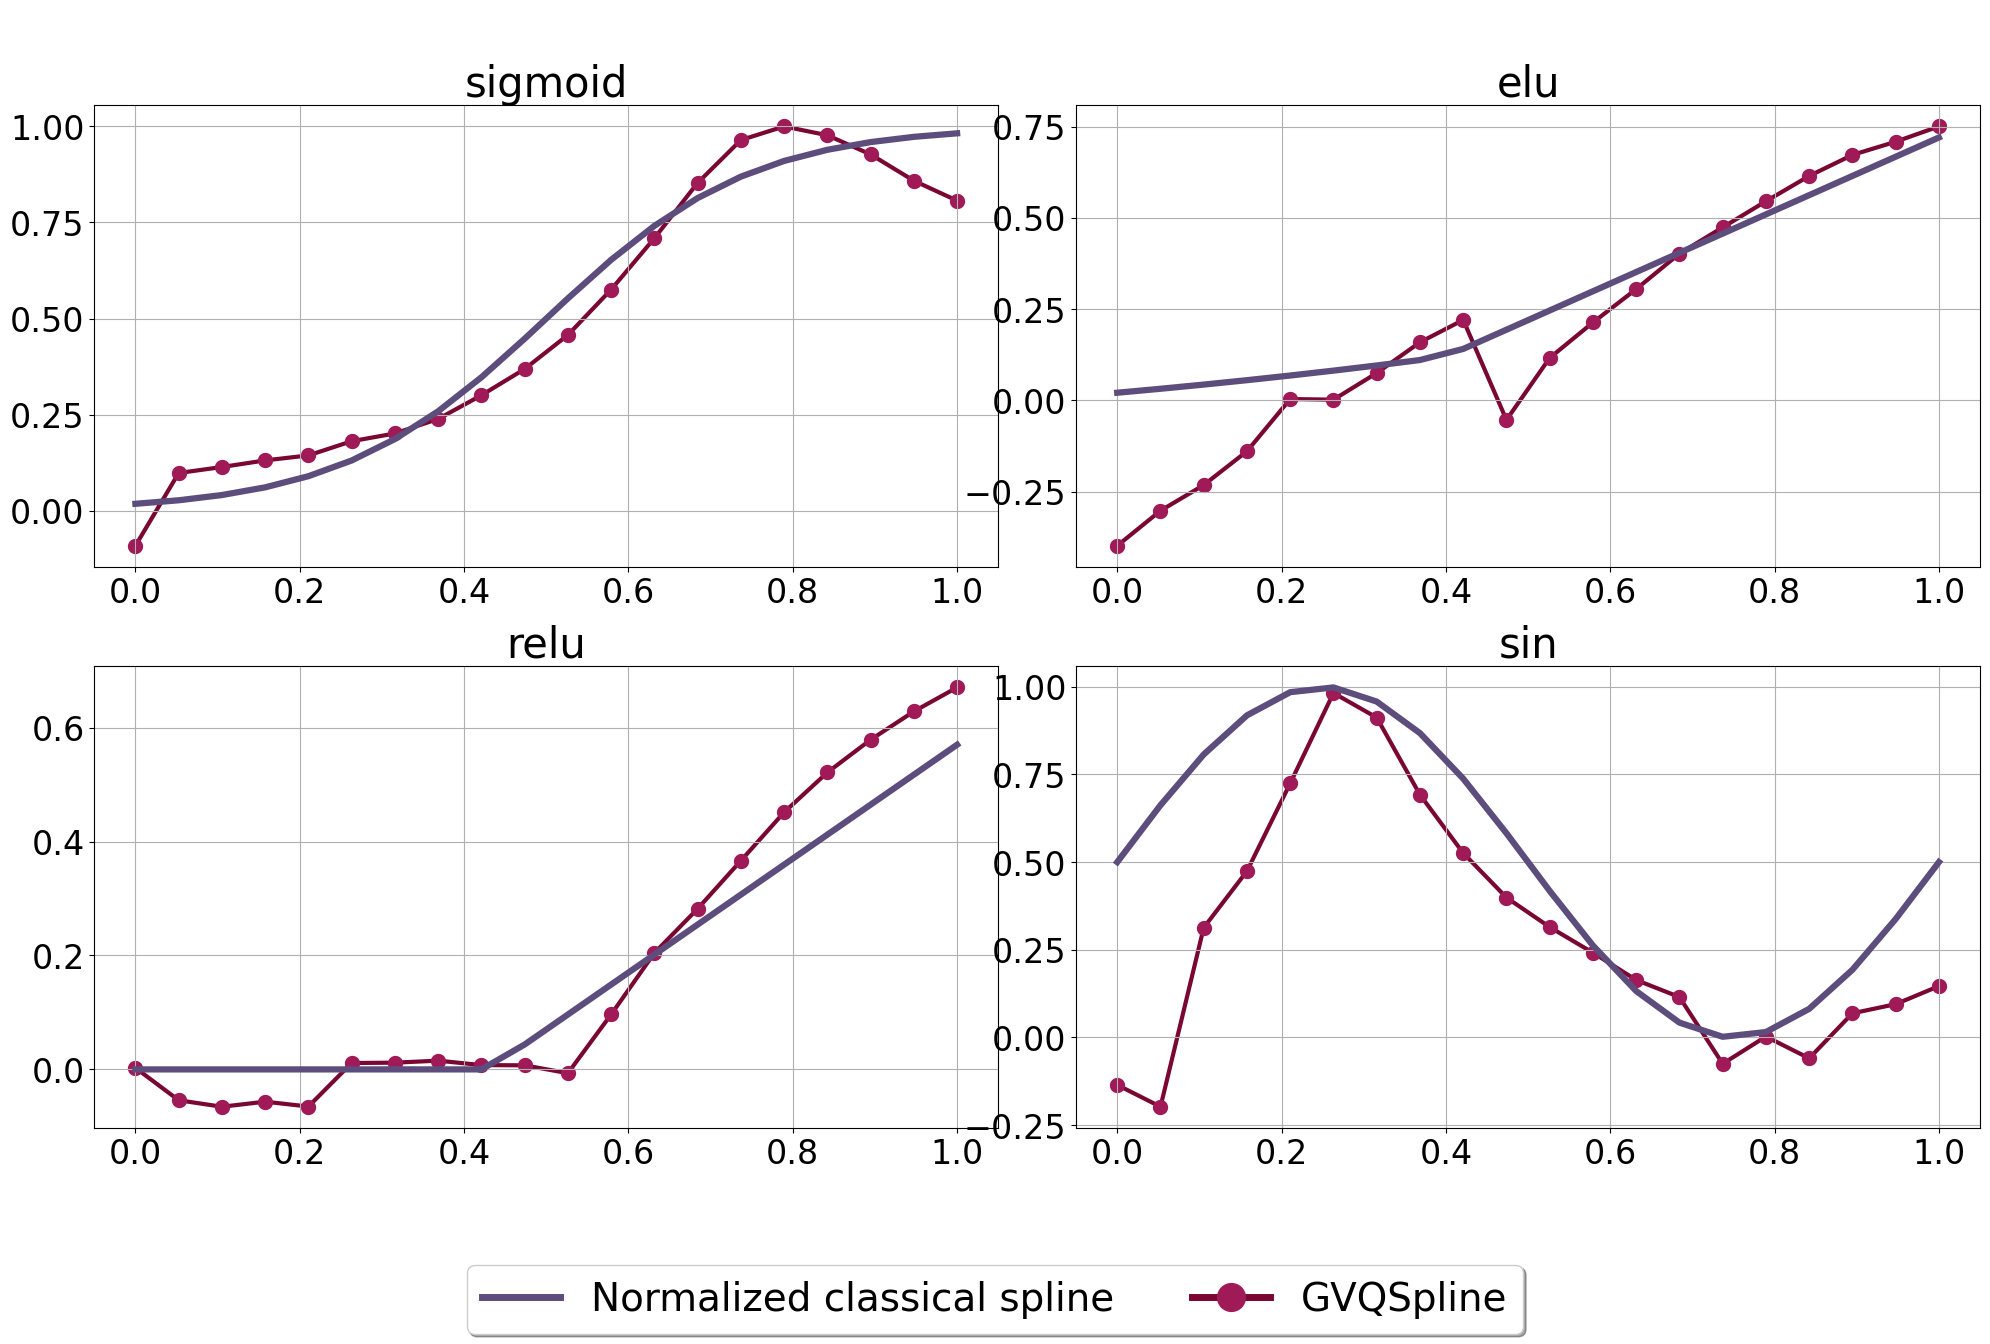

In [55]:
j = 0
k = 0
rss=[]
fig = plt.figure(tight_layout = True, figsize=(20,12))

fig.suptitle('Figure title')
axE = fig.subfigures(1,1,)

fig.suptitle(f'{flab}',fontsize=36)

ax = axE.subplots(nrows=2, ncols=2, sharey=False,)
fig.subplots_adjust(hspace=1)

for i, el in vqs_best.iterrows():
    y_fq = el['y_q']    
    nq, n_step = 1, 20
    flab = el.flab
    func = func_out[flab]
    f_i = func_dict[flab]
    xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
    y = [func(value,f_i) for value in xx]

    ax[k][j].tick_params(axis='both', which='major', labelsize=24)
    ax[k][j].grid(zorder = -3)
    ax[k][j].plot(xx,y,  label=f"Original function scaled {n_step}", color = '#5c4d7d',linewidth=4.5)

    colorl = '#7a0632'
    colors = '#a01a58'
    ax[k][j].plot(xx,y_fq, color=colorl, zorder= -1, lw=3)
    ax[k][j].scatter(xx,(y_fq), color=colors, linewidths=5)
    #plt.scatter(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
    #plt.plot(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
    #ax[i].text(0.35,0.87, f"rmse scaled = {rssss2:.4f}\n" \
    #    f"rmse classical = {rssss:.4f}\n", fontsize=14)
    ax[k][j].set_title(f'{flab}',fontsize=30)
    j-=-1
    if(j%2==0):
        j = 0
        k -=-1
handles = [mlines.Line2D([], [], color='#5c4d7d', linewidth=5, label='Normalized classical spline')]
#handles.append(mlines.Line2D([], [], color='#1780a1', linewidth=5, label='classical spline'))
handles.append(mlines.Line2D([], [], color=colorl, marker='.',linewidth=5,
                    markersize=40, label='GVQSpline', markerfacecolor=colors, markeredgecolor=colors))

lgd = axE.legend(handles = handles, loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5, fontsize = 28)



fig.savefig(f'plots/n_vqsplot.png', bbox_extra_artists=(lgd,), bbox_inches='tight')


## visualize gqs

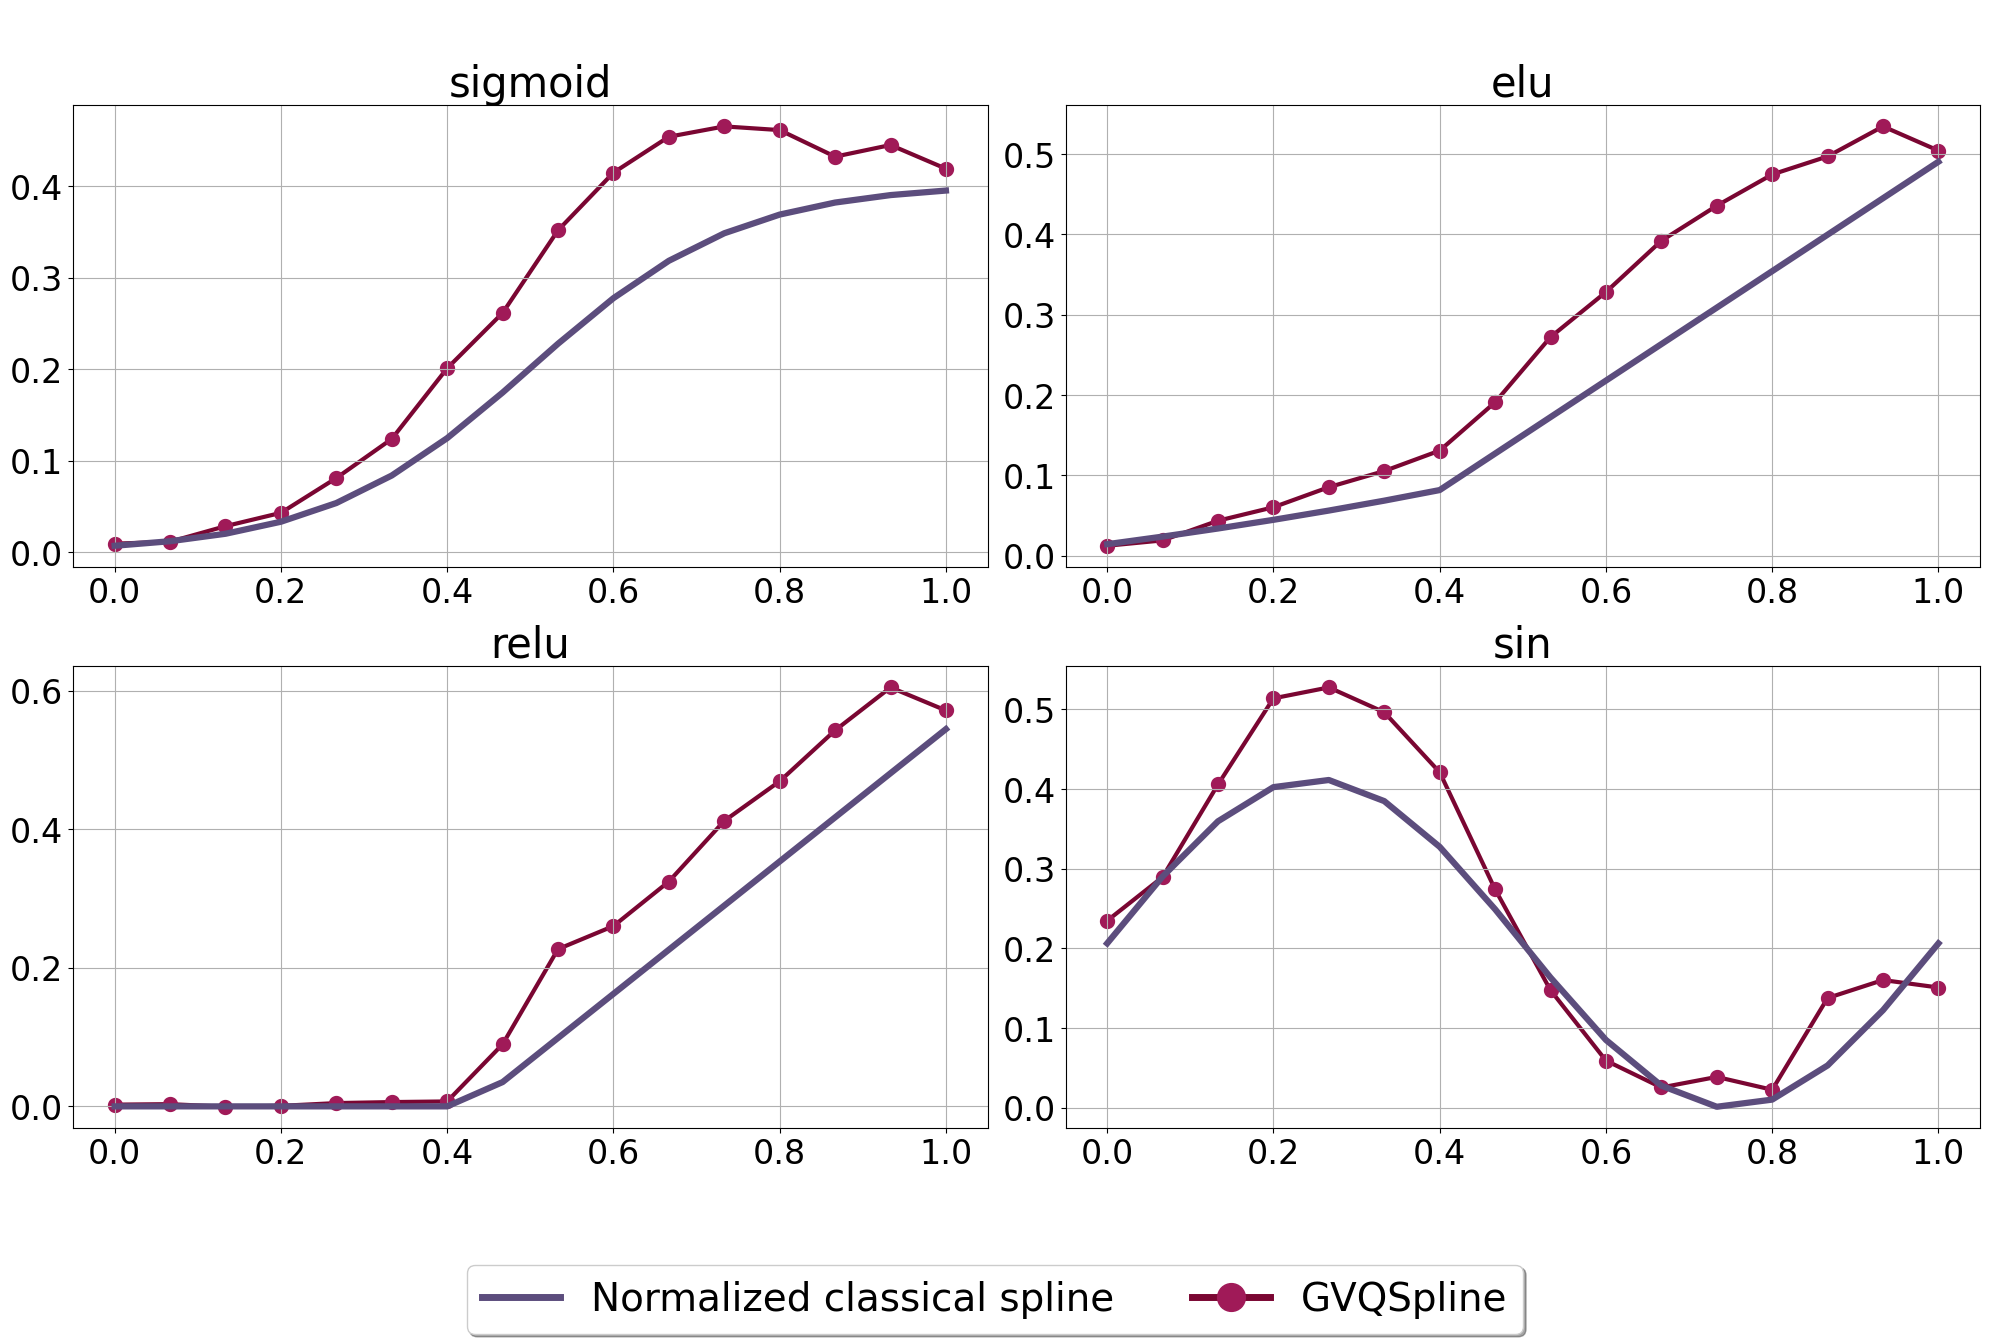

In [54]:
j = 0
k = 0
rss=[]
fig = plt.figure(tight_layout = True, figsize=(20,12))

pnqrvrs = {'8':(3,8),
        '16':(4,16)}

fig.suptitle('Figure title')
axE = fig.subfigures(1,1,)

fig.suptitle(f'{flab}',fontsize=36)

ax = axE.subplots(nrows=2, ncols=2, sharey=False,)
fig.subplots_adjust(hspace=1)

for i, el in gqs_best.iterrows():
    if el.knots==16:
        y_fq = el['y_q']    
        nq, n_step = pnqrvrs[str(el.knots)]
        flab = el.flab
        func = func_out[flab]
        f_i = func_dict[flab]
        xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
        y = [func(value,f_i) for value in xx]
        norm = np.linalg.norm(y)
        y = y / norm

        ax[k][j].tick_params(axis='both', which='major', labelsize=24)
        ax[k][j].grid(zorder = -3)
        ax[k][j].plot(xx,y,  label=f"Original function scaled {n_step}", color = '#5c4d7d',linewidth=4.5)

        colorl = '#7a0632'
        colors = '#a01a58'
        ax[k][j].plot(xx,y_fq, color=colorl, zorder= -1, lw=3)
        ax[k][j].scatter(xx,(y_fq), color=colors, linewidths=5)
        #plt.scatter(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
        #plt.plot(np.linspace(lower,upper,len(y_fq)),(y_q), label= f"hq {n_step}", color='blue')
        #ax[i].text(0.35,0.87, f"rmse scaled = {rssss2:.4f}\n" \
        #    f"rmse classical = {rssss:.4f}\n", fontsize=14)
        ax[k][j].set_title(f'{flab}',fontsize=30)
        j-=-1
        if(j%2==0):
            j = 0
            k -=-1
handles = [mlines.Line2D([], [], color='#5c4d7d', linewidth=5, label='Normalized classical spline')]
#handles.append(mlines.Line2D([], [], color='#1780a1', linewidth=5, label='classical spline'))
handles.append(mlines.Line2D([], [], color=colorl, marker='.',linewidth=5,
                    markersize=40, label='GVQSpline', markerfacecolor=colors, markeredgecolor=colors))

lgd = axE.legend(handles = handles, loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5, fontsize = 28)


fig.savefig(f'plots/n_gvqsplot.png', bbox_extra_artists=(lgd,), bbox_inches='tight')



# Table

In [41]:
vqs_trim=vqs_best.drop(['weights','y_q','seed' ], axis=1)
vqs_trim['model'] = ['vqs' for _ in range(vqs_trim.shape[0])]

In [42]:
gqs_trim=gqs_best.drop(['weights','y_q','seed' ], axis=1)
gqs_trim['model'] = ['gqs' for _ in range(gqs_trim.shape[0])]

In [53]:
a = pd.concat([vqs_trim, gqs_trim])
a['model'] = a['model'].astype('category')
print(a.pivot(['model', 'knots'],['flab']).to_markdown(tablefmt='latex_raw'))

\begin{tabular}{lrrrr}
\hline
             &   ('nrmse', 'elu') &   ('nrmse', 'relu') &   ('nrmse', 'sigmoid') &   ('nrmse', 'sin') \\
\hline
 ('gqs', 8)  &          1.04248   &          0.933029   &              1.21863   &          1.00348   \\
 ('gqs', 16) &          0.67573   &          0.587257   &              0.830236  &          0.733693  \\
 ('vqs', 20) &          0.0216174 &          0.00875655 &              0.0070207 &          0.0995349 \\
\hline
\end{tabular}


In [20]:
gqs_trim

,nrmse,flab,knots
0,1.218632,sigmoid,8
1,0.830236,sigmoid,16
2,1.042480,elu,8
3,0.675730,elu,16
4,0.933029,relu,8
5,0.587257,relu,16
6,1.003484,sin,8
7,0.733693,sin,16
